<a href="https://colab.research.google.com/github/wesleyroseno/colaboratory/blob/main/Curso_NVIDIA_RAPIDS_CuML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cuML - RAPIDS




## Instalação

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 4.28 MiB/s, done.
Resolving deltas: 100% (191/191), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.6/499.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
num = 10000
w = 2.0
x = np.random.normal(loc=0, scale=1, size=(num))

In [ ]:
x, x.shape

(array([-1.08150682, -0.07762801, -0.84312512, ...,  0.40000513,
        -0.49358782,  1.72200723]),
 (10000,))

In [ ]:
b = 1.0
y = w * x + b

In [ ]:
y, y.shape

(array([-1.16301365,  0.84474399, -0.68625025, ...,  1.80001026,
         0.01282437,  4.44401446]),
 (10000,))

In [ ]:
noise = np.random.normal(loc = 0, scale=2, size=(num,))
y_noisy = y + noise

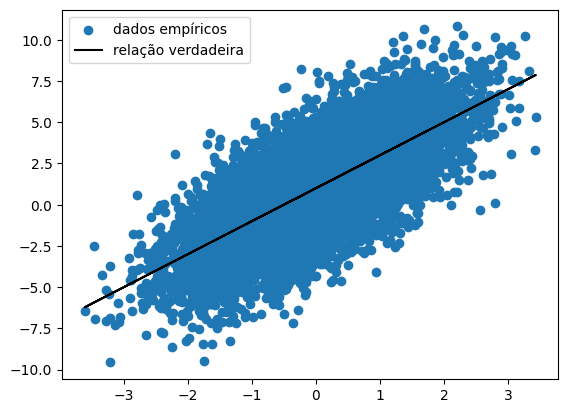

In [ ]:
plt.scatter(x, y_noisy, label='dados empíricos')
plt.plot(x, y, color = 'black', label='relação verdadeira')
plt.legend();

## Regressão Linear Simples


A classe LinearRegression implementada no cuML e no Scikit-Learn é baseada em mínimos quadrados ordinários (MQO, tradução de *ordinary least squares - OLS*), que essencialmente são responsáveis por minimizar a distância quadrada entre as observações (pontos azuis) e o relacionamento (linha preta) estimado pela classe.

Isso quer dizer que este é realmente um processo de otimização. O cuML oferece 3 algoritmos para ajustar o modelo linear:
* [Singular Value Decomposition (SVD)](https://www.geeksforgeeks.org/singular-value-decomposition-svd/) - é o mais estável
* [Eigendecomposition (Eig)](https://mathworld.wolfram.com/EigenDecomposition.html) - normalmente é muito mais rápido
* [Coordinate Descente (CD)](https://en.wikipedia.org/wiki/Coordinate_descent) - pode ser mais rápido para dados maiores

### Com o Scikit-Learn


In [ ]:
import sklearn
from sklearn.linear_model import LinearRegression
print(sklearn.__version__)

1.2.2


In [ ]:
linear_regression = LinearRegression()
type(linear_regression)

sklearn.linear_model._base.LinearRegression

In [ ]:
x.shape

(10000,)

In [ ]:
np.expand_dims(x, 1).shape

(10000, 1)

In [ ]:
linear_regression.fit(np.expand_dims(x, 1), y_noisy)

LinearRegression()

In [ ]:
type(x), type(y_noisy)

(numpy.ndarray, numpy.ndarray)

In [ ]:
inputs = np.linspace(start=-5, stop=5, num=1000000)

In [ ]:
inputs

array([-5.     , -4.99999, -4.99998, ...,  4.99998,  4.99999,  5.     ])

In [ ]:
outputs = linear_regression.predict(np.expand_dims(inputs, 1))
outputs

array([-9.17151622, -9.17149592, -9.17147563, ..., 11.12102563,
       11.12104593, 11.12106622])

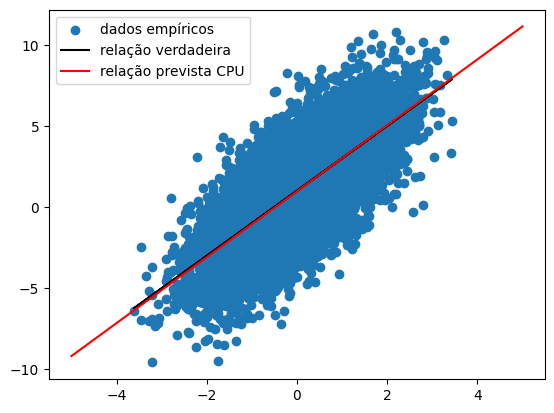

In [ ]:
plt.scatter(x, y_noisy, label = 'dados empíricos')
plt.plot(x, y, color='black', label = 'relação verdadeira')
plt.plot(inputs, outputs, color='red', label = 'relação prevista CPU')
plt.legend();

### Com o cuML

In [ ]:
import cudf
print(cudf.__version__)

23.08.00


In [ ]:
df = cudf.DataFrame({'x': x, 'y': y_noisy})
df.head()

,x,y
0,-1.081507,0.591791
1,-0.077628,2.752006
2,-0.843125,-1.704514
3,-0.060676,1.296668
4,0.150852,2.879007


In [ ]:
type(df)

cudf.core.dataframe.DataFrame

In [ ]:
import cuml
print(cuml.__version__)
from cuml.linear_model import LinearRegression as LinearRegressionGPU

23.08.00


In [ ]:
df['x']

0      -1.081507
1      -0.077628
2      -0.843125
3      -0.060676
4       0.150852
          ...   
9995   -1.539895
9996   -1.767906
9997    0.400005
9998   -0.493588
9999    1.722007
Name: x, Length: 10000, dtype: float64

In [ ]:
import cupy as cp
linear_regression_gpu = LinearRegressionGPU()
linear_regression_gpu.fit(cp.expand_dims(cp.array(df['x']), 1), cp.array(y_noisy))

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:190: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


LinearRegression()

In [ ]:
df_cudf = cudf.DataFrame({'inputs': inputs})
df_cudf

,inputs
0,-5.00000
1,-4.99999
2,-4.99998
3,-4.99997
4,-4.99996
...,...
999995,4.99996
999996,4.99997
999997,4.99998
999998,4.99999


In [ ]:
type(df_cudf)

cudf.core.dataframe.DataFrame

In [ ]:
outputs_gpu = linear_regression_gpu.predict(df_cudf[['inputs']])

In [ ]:
type(outputs_gpu)

cupy.ndarray

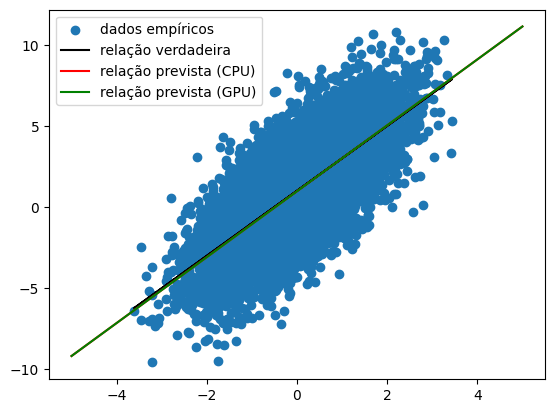

In [ ]:
plt.scatter(x, y_noisy, label='dados empíricos')
plt.plot(x, y, color='black', label='relação verdadeira')
plt.plot(inputs, outputs, color='red', label='relação prevista (CPU)')
plt.plot(inputs, outputs_gpu.get(), color='green', label='relação prevista (GPU)')
plt.legend();

## Ridge Regression e Hiperparâmetros


Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [ ]:
from sklearn import datasets
diabetes = datasets.load_diabetes()

In [ ]:
type(diabetes)

sklearn.utils._bunch.Bunch

In [ ]:
diabetes

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990749, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06833155, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286131, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04688253,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452873, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00422151,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.2)

In [ ]:
X_train.shape, y_train.shape

((353, 10), (353,))

In [ ]:
X_test.shape, y_test.shape

((89, 10), (89,))

In [ ]:
from cuml import Ridge as cuRidge
from sklearn.linear_model import Ridge as skRidge

In [ ]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [ ]:
alpha = np.array([1.0])
fit_intercept = True

ridge = skRidge(alpha=alpha, fit_intercept=fit_intercept, solver='cholesky')
ridge.fit(X_train, y_train)

Ridge(alpha=array([1.]), solver='cholesky')

> Para o cuML

In [ ]:
import cupy as cp
X_train_cp = cp.array(X_train)
y_train_cp = cp.array(y_train)

In [ ]:
type(X_train_cp), type(y_train_cp)

(cupy.ndarray, cupy.ndarray)

In [ ]:
cuml_ridge = cuRidge(alpha=alpha, fit_intercept=fit_intercept, solver='eig')
cuml_ridge.fit(X_train_cp, y_train_cp)

Ridge()

> Documentação do cuML: https://docs.rapids.ai/api/cuml/stable/api.html#regression-and-classification

## Predição dos valores e avaliação

In [ ]:
X_test.shape, y_test.shape

((89, 10), (89,))

In [ ]:
type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray)

In [ ]:
print('sklearn: ' + str(ridge.score(X_test, y_test)))

sklearn: 0.38415670031782856


In [ ]:
print('cuML: ' + str(cuml_ridge.score(cp.array(X_test), cp.array(y_test))))

cuML: 0.38415670031782867


## Melhorando a acurácia dos modelos com Tuning dos parâmetros

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
np.logspace(-3, -1, 10)

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

In [ ]:
params = {'alpha': np.logspace(-3, -1, 10)}

In [ ]:
grid = GridSearchCV(ridge, params, scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(estimator=Ridge(alpha=array([1.]), solver='cholesky'),
             param_grid={'alpha': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])},
             scoring='r2')

In [ ]:
grid.best_params_

{'alpha': 0.03593813663804626}

In [ ]:
grid.best_score_

0.5110710219115666

In [ ]:
grid.best_params_['alpha']

0.03593813663804626

In [ ]:
ridge = skRidge(alpha = grid.best_params_['alpha'],
                fit_intercept=fit_intercept,
                solver='cholesky')
ridge.fit(X_train, y_train)

Ridge(alpha=0.03593813663804626, solver='cholesky')

### Otimização de hiperparâmetros para o cuML

In [ ]:
cuml_grid = GridSearchCV(cuml_ridge, params, scoring='r2')
cuml_grid.fit(X_train, y_train)
cuml_grid.best_params_, cuml_grid.best_score_

({'alpha': 0.03593813663804626}, 0.5110710219115666)

In [ ]:
cuml_ridge = cuRidge(alpha=cuml_grid.best_params_['alpha'], fit_intercept=fit_intercept, solver='eig')
cuml_ridge.fit(X_train_cp, y_train_cp)

Ridge()

# Comparações de desempenho  

- Documentação: https://github.com/rapidsai/cuml/blob/7d86042b8/python/cuml/benchmark/runners.py#L56

In [ ]:
from cuml.benchmark.runners import SpeedupComparisonRunner
from cuml.benchmark.algorithms import algorithm_by_name
import pandas as pd

In [ ]:
num_reps = 3
dataset_neighborhoods = 'blobs'
dataset_classification = 'classification'
dataset_regression = 'regression'
input_type = 'numpy'

In [ ]:
for x in range(14, 17):
  print(x)

14
15
16


In [ ]:
2 ** 16

65536

In [ ]:
bechmark_results = []
row_sizes = [2**x for x in range(14, 17)]
row_sizes

[16384, 32768, 65536]

In [ ]:
features = [32, 256]

In [ ]:
def dic_result(algorithm, runner, result):
  result["algo"] = algorithm
  result["dataset_name"] = runner.dataset_name
  result["input_type"] = runner.input_type
  return result

In [ ]:
def benchmark(algorithm, runner, verbose=True, run_cpu=True, **kwargs):
  results = runner.run(algorithm_by_name(algorithm), verbose=verbose, run_cpu=run_cpu, **kwargs)
  results = [dic_result(algorithm, runner, result) for result in results]
  bechmark_results.extend(results)

## Regressão Linear

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows = row_sizes,
    bench_dims = features,
    dataset_name=dataset_regression,
    input_type=input_type,
    n_reps=num_reps
)

In [ ]:
benchmark("LinearRegression", runner)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


LinearRegression (n_samples=16384, n_features=32) [cpu=0.01584315299987793, gpu=0.004697322845458984, speedup=3.372804791391737]


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


LinearRegression (n_samples=16384, n_features=256) [cpu=0.39600586891174316, gpu=0.018358945846557617, speedup=21.570185577185306]


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


LinearRegression (n_samples=32768, n_features=32) [cpu=0.03437924385070801, gpu=0.0049724578857421875, speedup=6.913933640199463]


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


LinearRegression (n_samples=32768, n_features=256) [cpu=0.738985538482666, gpu=0.027767658233642578, speedup=26.613174660415915]


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


LinearRegression (n_samples=65536, n_features=32) [cpu=0.059273719787597656, gpu=0.006335258483886719, speedup=9.356164383561644]


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)


LinearRegression (n_samples=65536, n_features=256) [cpu=1.2895750999450684, gpu=0.037778615951538086, speedup=34.13505411631063]


In [ ]:
bechmark_results

[{'cuml_time': 0.004697322845458984,
  'cpu_time': 0.01584315299987793,
  'speedup': 3.372804791391737,
  'n_samples': 16384,
  'n_features': 32,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'cuml_time': 0.018358945846557617,
  'cpu_time': 0.39600586891174316,
  'speedup': 21.570185577185306,
  'n_samples': 16384,
  'n_features': 256,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'cuml_time': 0.0049724578857421875,
  'cpu_time': 0.03437924385070801,
  'speedup': 6.913933640199463,
  'n_samples': 32768,
  'n_features': 32,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'cuml_time': 0.027767658233642578,
  'cpu_time': 0.738985538482666,
  'speedup': 26.613174660415915,
  'n_samples': 32768,
  'n_features': 256,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'cuml_time': 0.006335258483886719,
  'cpu_time': 0.05927371

Para cada benchmark:
 * 'cuml_time' - tempo levado com o cuML (GPU)
 * 'cpu_time' - tempo levado para o scikit-learn (CPU)
 * 'speedup' - a aceleração
 * 'n_samples': número de amostras (será correspondente a um dos row_sizes, que definimos mais acima)
 * 'n_features' - número de features
 * 'algo' - o algoritmo usado
 * 'dataset_name' - dataset usado para o teste

## KMeans

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=row_sizes,
    bench_dims=features,
    dataset_name=dataset_neighborhoods,
    input_type=input_type,
    n_reps=num_reps
)

benchmark("KMeans", runner)

KMeans (n_samples=16384, n_features=32) [cpu=0.1534581184387207, gpu=0.03334498405456543, speedup=4.60213500740031]
KMeans (n_samples=16384, n_features=256) [cpu=0.509784460067749, gpu=0.04548192024230957, speedup=11.208507849972479]
KMeans (n_samples=32768, n_features=32) [cpu=0.8709063529968262, gpu=0.04580974578857422, speedup=19.01137712084938]
KMeans (n_samples=32768, n_features=256) [cpu=0.9852688312530518, gpu=0.1072683334350586, speedup=9.185085660434392]
KMeans (n_samples=65536, n_features=32) [cpu=0.2306687831878662, gpu=0.12254881858825684, speedup=1.8822603583219684]
KMeans (n_samples=65536, n_features=256) [cpu=2.247256278991699, gpu=0.21094202995300293, speedup=10.653430610734045]


## Random Forest

In [ ]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=row_sizes,
    bench_dims=features,
    dataset_name=dataset_classification,
    input_type=input_type,
    n_reps=num_reps
)

benchmark("RandomForestClassifier", runner)

RandomForestClassifier (n_samples=16384, n_features=32) [cpu=3.3615262508392334, gpu=0.1304643154144287, speedup=25.765867395702173]
RandomForestClassifier (n_samples=16384, n_features=256) [cpu=15.094930171966553, gpu=0.1881999969482422, speedup=80.20685662454014]
RandomForestClassifier (n_samples=32768, n_features=32) [cpu=7.160955429077148, gpu=0.15050387382507324, speedup=47.57987450475954]
RandomForestClassifier (n_samples=32768, n_features=256) [cpu=33.984272718429565, gpu=0.25351428985595703, speedup=134.0526908275621]
RandomForestClassifier (n_samples=65536, n_features=32) [cpu=21.15307354927063, gpu=0.24306797981262207, speedup=87.02533984763134]
RandomForestClassifier (n_samples=65536, n_features=256) [cpu=98.83052086830139, gpu=0.4168837070465088, speedup=237.06976117748724]


## Exibindo os gráficos comparativos



In [ ]:
df = pd.DataFrame(bechmark_results)
df

,cuml_time,cpu_time,speedup,n_samples,n_features,algo,dataset_name,input_type
0,0.004697,0.015843,3.372805,16384,32,LinearRegression,regression,numpy
1,0.018359,0.396006,21.570186,16384,256,LinearRegression,regression,numpy
2,0.004972,0.034379,6.913934,32768,32,LinearRegression,regression,numpy
3,0.027768,0.738986,26.613175,32768,256,LinearRegression,regression,numpy
4,0.006335,0.059274,9.356164,65536,32,LinearRegression,regression,numpy
5,0.037779,1.289575,34.135054,65536,256,LinearRegression,regression,numpy
6,0.033345,0.153458,4.602135,16384,32,KMeans,blobs,numpy
7,0.045482,0.509784,11.208508,16384,256,KMeans,blobs,numpy
8,0.045810,0.870906,19.011377,32768,32,KMeans,blobs,numpy
9,0.107268,0.985269,9.185086,32768,256,KMeans,blobs,numpy


In [ ]:
def plot_speedup(df, algorithm):
  df = df.loc[df.algo == algorithm]
  df = df.pivot(index = "n_samples", columns="n_features", values = "speedup")
  axes = df.plot.bar(title = "Aceleração com %s" % algorithm, rot = 0)

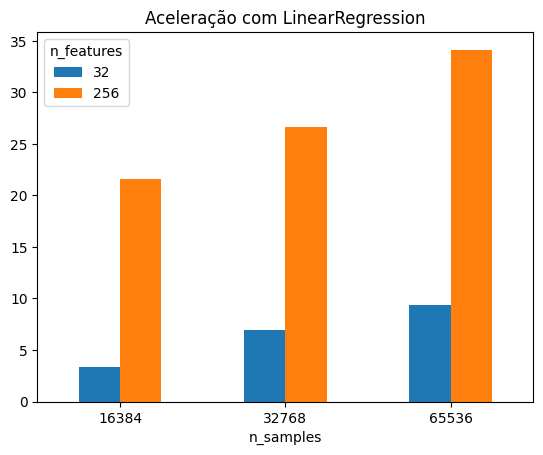

In [ ]:
plot_speedup(df, "LinearRegression")

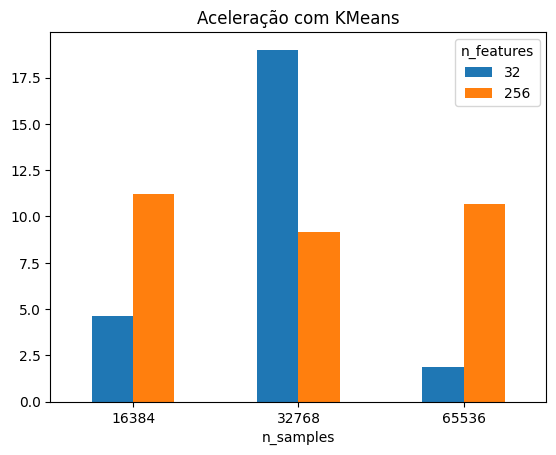

In [ ]:
plot_speedup(df, "KMeans")

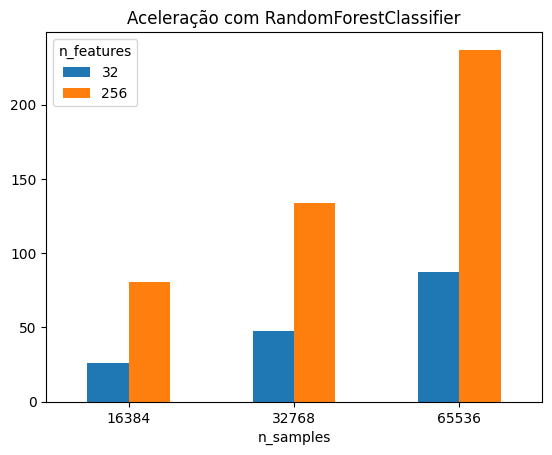

In [ ]:
plot_speedup(df, "RandomForestClassifier")

In [ ]:
def plot_speedup_multi(df):
  df = df[["algo", "n_samples", "speedup"]].groupby(["algo", "n_samples"]).mean()
  df.plot.bar()

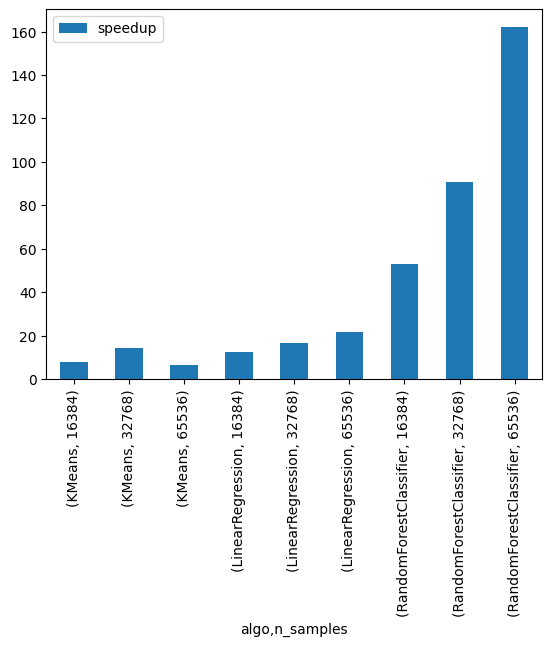

In [ ]:
plot_speedup_multi(df)

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!nvidia-smi

Thu Sep 14 13:59:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |   1383MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------